# Capstone Project - The Battle of Neighborhoods: Paris Restaurants

###           Segmenting and Clustering Neighborhoods in Paris City

## Table of Contents

   1. Download and Explore Dataset

   2. Explore Neighborhoods in Paris City

   3. Analyze Each Neighborhood

   4. Cluster Neighborhoods

   5. Examine Clusters



Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import geopandas as gpd

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Sol

<a id='item1'></a>

## 1. Download and Explore Dataset

Paris has a total of 20 boroughs and 80 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 20 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

This dataset exists for free on the web.Here is the link to the dataset: https://www.data.gouv.fr/fr/datasets/quartiers-administratifs/quartier_paris.csv

#### Load and explore the data

Next, let's load the data.

In [2]:
df=pd.read_csv('quartier_paris.csv',sep=';')

In [3]:
df.shape

(80, 10)

In [4]:
df.head()

,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry
0,750000036,36,7510904,Rochechouart,9,750000009,2862.450525,5.004354e+05,"48.8798119198,2.344861291","{""type"": ""Polygon"", ""coordinates"": [[[2.349708..."
1,750000047,47,7511203,Bercy,12,750000012,6155.005036,1.902932e+06,"48.8352090499,2.38621008421","{""type"": ""Polygon"", ""coordinates"": [[[2.391141..."
2,750000002,2,7510102,Halles,1,750000001,2606.417128,4.124585e+05,"48.8622891081,2.34489885831","{""type"": ""Polygon"", ""coordinates"": [[[2.349365..."
3,750000015,15,7510403,Arsenal,4,750000004,2878.559656,4.872649e+05,"48.851585175,2.36476795387","{""type"": ""Polygon"", ""coordinates"": [[[2.368512..."
4,750000018,18,7510502,Jardin-des-Plantes,5,750000005,4052.729521,7.983894e+05,"48.8419401934,2.35689388962","{""type"": ""Polygon"", ""coordinates"": [[[2.364561..."


### Data Cleaning

Let's take a quick look at the data.

In [5]:
df.rename(columns={'L_QU':'Neighborhood','C_AR':'Borough'},inplace=True)
df['Longitude']=df['Geometry X Y'].str.split(',',expand=True)[1].astype(float)
df['Latitude']=df['Geometry X Y'].str.split(',',expand=True)[0].astype(float)


In [6]:
df.head()

,N_SQ_QU,C_QU,C_QUINSEE,Neighborhood,Borough,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry,Longitude,Latitude
0,750000036,36,7510904,Rochechouart,9,750000009,2862.450525,5.004354e+05,"48.8798119198,2.344861291","{""type"": ""Polygon"", ""coordinates"": [[[2.349708...",2.344861,48.879812
1,750000047,47,7511203,Bercy,12,750000012,6155.005036,1.902932e+06,"48.8352090499,2.38621008421","{""type"": ""Polygon"", ""coordinates"": [[[2.391141...",2.386210,48.835209
2,750000002,2,7510102,Halles,1,750000001,2606.417128,4.124585e+05,"48.8622891081,2.34489885831","{""type"": ""Polygon"", ""coordinates"": [[[2.349365...",2.344899,48.862289
3,750000015,15,7510403,Arsenal,4,750000004,2878.559656,4.872649e+05,"48.851585175,2.36476795387","{""type"": ""Polygon"", ""coordinates"": [[[2.368512...",2.364768,48.851585
4,750000018,18,7510502,Jardin-des-Plantes,5,750000005,4052.729521,7.983894e+05,"48.8419401934,2.35689388962","{""type"": ""Polygon"", ""coordinates"": [[[2.364561...",2.356894,48.841940


In [7]:
df.dtypes

N_SQ_QU           int64
C_QU              int64
C_QUINSEE         int64
Neighborhood     object
Borough           int64
N_SQ_AR           int64
PERIMETRE       float64
SURFACE         float64
Geometry X Y     object
Geometry         object
Longitude       float64
Latitude        float64
dtype: object

In [8]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods=df[column_names]
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 20 boroughs and 80 neighborhoods.


 The boroughs are identified by their number from 1 to 20.

In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,9,Rochechouart,48.879812,2.344861
1,12,Bercy,48.835209,2.386210
2,1,Halles,48.862289,2.344899
3,4,Arsenal,48.851585,2.364768
4,5,Jardin-des-Plantes,48.841940,2.356894


#### Use geopy library to get the latitude and longitude values of Paris City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [10]:
address = 'Paris'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address, timeout=10)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris City are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Paris City are 48.8566969, 2.3514616.


#### Create a map of Paris with neighborhoods superimposed on top.

In [11]:
# create map of Paris using latitude and longitude values
map_Paris = folium.Map(location=[48.8566969, 2.3514616], zoom_start=10)
# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Paris)  
    
map_Paris

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = '4TFWLROI2BT5M3ZSNJGNFDIC3GFHYB0424Q14YFG10UHVG2V' # your Foursquare ID
CLIENT_SECRET = 'VYVFJ0RZPWR3FVOR4CTOJTOQ11XQS2UJ1O1AD2XEY5YQJKXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4TFWLROI2BT5M3ZSNJGNFDIC3GFHYB0424Q14YFG10UHVG2V
CLIENT_SECRET:VYVFJ0RZPWR3FVOR4CTOJTOQ11XQS2UJ1O1AD2XEY5YQJKXX


#### Now, let's get the top 100 venues that are in Paris center within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [13]:
# type your answer here

neighborhood_latitude=48.8566969
neighborhood_longitude=2.3514616
#35.818928 	10.629749
#35.828829, 10.64052
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL




'https://api.foursquare.com/v2/venues/explore?&client_id=4TFWLROI2BT5M3ZSNJGNFDIC3GFHYB0424Q14YFG10UHVG2V&client_secret=VYVFJ0RZPWR3FVOR4CTOJTOQ11XQS2UJ1O1AD2XEY5YQJKXX&v=20180605&ll=48.8566969,2.3514616&radius=500&limit=100'

Send the GET request and examine the resutls

In [14]:
results = requests.get(url).json()
#results

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Place de l'Hôtel de Ville – Esplanade de la Li...,Plaza,48.856925,2.351412
1,Parc Rives de Seine,Park,48.855510,2.351419
2,L'Alsacien,Alsatian Restaurant,48.858275,2.350381
3,Berges de Seine – Rive droite,Pedestrian Plaza,48.855131,2.352289
4,Maison Aleph,Pastry Shop,48.857348,2.354873


And how many venues were returned by Foursquare?

In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore Neighborhoods in Paris

Let's create a function to repeat the same process to all the neighborhoods in Paris, we will select only food category with the Id=4d4b7105d754a06374d81259

In [18]:
def getNearbyRestaurants(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL filtering by Food Category
        url = 'https://api.foursquare.com/v2/venues/search?&categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['venues']
        except KeyError:
            print("no restaurants: {} ".format(name))
            continue;
            
        if len(results) == 0:
            print("no restaurants: {} ".format(name))
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    v['categories'][0]['name'])])
            except IndexError:
                print("Index Error: {}".format(v['name']))

    nearby_restaurants = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_restaurants.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_restaurants)

In [19]:
# type your answer here

Paris_restaurants = getNearbyRestaurants(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )



no restaurants: Picpus 


In [20]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,9,Rochechouart,48.879812,2.344861
1,12,Bercy,48.835209,2.386210
2,1,Halles,48.862289,2.344899
3,4,Arsenal,48.851585,2.364768
4,5,Jardin-des-Plantes,48.841940,2.356894


In [21]:
print(Paris_restaurants.shape)


(3741, 7)


In [22]:
Paris_restaurants.to_csv('Paris_restaurants.csv',index=False)

#### The final dataframe named as Paris_restaurants is structured as following:

In [23]:
Paris_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rochechouart,48.879812,2.344861,Mamiche,48.880112,2.343699,Bakery
1,Rochechouart,48.879812,2.344861,Pizza di Loretta,48.880634,2.344011,Pizza Place
2,Rochechouart,48.879812,2.344861,Lakshmi Bhavan,48.881077,2.344232,Indian Restaurant
3,Rochechouart,48.879812,2.344861,Le Barbe à Papa,48.879654,2.347438,French Restaurant
4,Rochechouart,48.879812,2.344861,Pain Pain,48.883651,2.339841,Bakery


Let's check how many venues were returned for each neighborhood

In [24]:
Paris_restaurants.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Amérique,49,49,49,49,49,49
Archives,50,50,50,50,50,50
Arsenal,49,49,49,49,49,49
Arts-et-Métiers,50,50,50,50,50,50
Auteuil,11,11,11,11,11,11


#### Let's find out how many unique categories can be curated from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(Paris_restaurants['Venue Category'].unique())))

There are 153 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [26]:
# one hot encoding
Paris_onehot = pd.get_dummies(Paris_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Paris_onehot['Neighborhood'] = Paris_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Paris_onehot.columns[-1]] + list(Paris_onehot.columns[:-1])
Paris_onehot = Paris_onehot[fixed_columns]

Paris_onehot.head()

,Neighborhood,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basque Restaurant,Beer Garden,Belgian Restaurant,Bistro,Bookstore,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burgundian Restaurant,Burrito Place,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Convenience Store,Corsican Restaurant,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Eastern European Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fondue Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gas Station,Gastropub,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Halal Restaurant,Hawaiian Restaurant,Health Food Store,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Labour Canteen,Latin American Restaurant,Lebanese Restaurant,Lounge,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Non-Profit,Noodle House,North Indian Restaurant,Okonomiyaki Restaurant,Organic Grocery,Pastry Shop,Persian Restaurant,Peruvian Restaurant,Pie Shop,Pizza Place,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanxi Restaurant,Shopping Plaza,Smoke Shop,Snack Place,Soup Place,South American Restaurant,Southwestern French Restaurant,Spanish Restaurant,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tourist Information Center,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Rochechouart,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rochechouart,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Rochechouart,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Rochechouart,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Rochechouart,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [27]:
Paris_onehot.shape

(3741, 154)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
Paris_grouped = Paris_onehot.groupby('Neighborhood').mean().reset_index()
Paris_grouped.head()

,Neighborhood,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basque Restaurant,Beer Garden,Belgian Restaurant,Bistro,Bookstore,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burgundian Restaurant,Burrito Place,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Convenience Store,Corsican Restaurant,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Eastern European Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fondue Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gas Station,Gastropub,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Halal Restaurant,Hawaiian Restaurant,Health Food Store,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Labour Canteen,Latin American Restaurant,Lebanese Restaurant,Lounge,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Non-Profit,Noodle House,North Indian Restaurant,Okonomiyaki Restaurant,Organic Grocery,Pastry Shop,Persian Restaurant,Peruvian Restaurant,Pie Shop,Pizza Place,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanxi Restaurant,Shopping Plaza,Smoke Shop,Snack Place,Soup Place,South American Restaurant,Southwestern French Restaurant,Spanish Restaurant,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tourist Information Center,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Amérique,0.0,0.0,0.0,0.0,0.00,0.0,0.081633,0.0,0.0,0.000000,0.102041,0.000000,0.0,0.0,0.0,0.040816,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.0,0.0,0.0,0.0,0.081633,0.0,0.0,0.0,0.0,0.0,0.020408,0.00,0.0,0.0,0.020408,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.040816,0.0,0.0,0.0,0.0,0.0,0.020408,0.0,0.061224,0.020408,0.0,0.0,0.0,0.0,0.0,0.122449,0.0,0.0,0.020408,0.0,0.00,0.000000,0.020408,0.0,0.0,0.0,0.00,0.000000,0.020408,0.0,0.0,0.0,0.061224,0.020408,0.0,0.00,0.0,0.0,0.00,0.0,0.020408,0.020408,0.00,0.0,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.081633,0.0,0.0,0.0,0.040816,0.0,0.0,0.00,0.000000,0.020408,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.020408,0.00,0.00,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020408,0.0,0.0
1,Archives,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.000000,0.080000,0.020000,0.0,0.0,0.0,0.120000,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.080000,0.0,0.0,0.0,0.0,0.0,0.000000,0.02,0.0,0.0,0.040000,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.02,0.040000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.060000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.120000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.00,0.020000,0.000000,0.0,0.0,0.0,0.020000,0.020000,0.0,0.02,0.0,0.0,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.02,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.02,0.0,0.02,0.0,0.02,0.0,0.020000,0.0,0.0,0.0,0.020000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0

#### Let's confirm the new size

In [29]:
Paris_grouped.shape

(79, 154)

#### Let's print each neighborhood along with the top 5 most common venues

In [30]:
num_top_venues = 5

for hood in Paris_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = Paris_grouped[Paris_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Paris_grouped['Neighborhood']

for ind in np.arange(Paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,French Restaurant,Bakery,Asian Restaurant,Pizza Place,Café,Italian Restaurant,Fast Food Restaurant,Bistro,Diner,Restaurant
1,Archives,Bistro,French Restaurant,Café,Bakery,Tea Room,Falafel Restaurant,Coffee Shop,Creperie,Dessert Shop,Mexican Restaurant
2,Arsenal,French Restaurant,Café,Bakery,Thai Restaurant,Gastropub,Coffee Shop,Bar,Italian Restaurant,Southwestern French Restaurant,South American Restaurant
3,Arts-et-Métiers,French Restaurant,Café,Bakery,Bistro,Coffee Shop,Pizza Place,Chinese Restaurant,Bar,Restaurant,Gastropub
4,Auteuil,French Restaurant,Restaurant,Sandwich Place,Café,Shopping Plaza,Doner Restaurant,Diner,Dim Sum Restaurant,Dessert Shop,Deli / Bodega


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run k-means to cluster the neighborhood into 3 clusters.

In [33]:
Paris_grouped_clustering = Paris_grouped.drop('Neighborhood', 1)

In [34]:
X=Paris_grouped_clustering

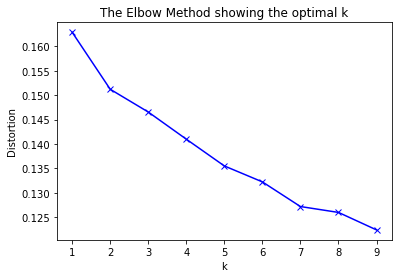

In [35]:
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

 

We will use the KMeans algorithm to cluster our dataset. The elbow method helps us to find the optimal value for number of clusters k.

We can see in the figure above,when k increases, the centroids are closer to the clusters centroids.

The improvements will decline, at some point rapidly, creating the elbow shape.

The plot looks like an arm with an elbow at k = 3 ,so that point is the optimal value for k.


In [36]:
# set number of clusters
kclusters = 3

Paris_grouped_clustering = Paris_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 0, 0, 1, 2, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Paris_merged = neighborhoods

# merge Paris_grouped with Paris_data to add latitude/longitude for each neighborhood
Paris_merged = Paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Paris_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,9,Rochechouart,48.879812,2.344861,1.0,Bakery,French Restaurant,Burger Joint,Café,Deli / Bodega,Bistro,Dessert Shop,Coffee Shop,Vegetarian / Vegan Restaurant,Fast Food Restaurant
1,12,Bercy,48.835209,2.386210,1.0,Bakery,Japanese Restaurant,Sushi Restaurant,French Restaurant,Italian Restaurant,Café,Fast Food Restaurant,Bistro,Pizza Place,Cafeteria
2,1,Halles,48.862289,2.344899,0.0,French Restaurant,Bakery,Cocktail Bar,Café,Fast Food Restaurant,Bistro,Steakhouse,Salad Place,Coffee Shop,Latin American Restaurant
3,4,Arsenal,48.851585,2.364768,0.0,French Restaurant,Café,Bakery,Thai Restaurant,Gastropub,Coffee Shop,Bar,Italian Restaurant,Southwestern French Restaurant,South American Restaurant
4,5,Jardin-des-Plantes,48.841940,2.356894,1.0,French Restaurant,Bakery,Fast Food Restaurant,Restaurant,Café,Pizza Place,Tea Room,Thai Restaurant,Coffee Shop,Creperie


In [38]:
Paris_merged.dropna(inplace=True)

In [39]:
Paris_merged.shape

(79, 15)

In [40]:
Paris_merged['Cluster Labels']=Paris_merged['Cluster Labels'].astype(int)

Finally, let's visualize the resulting clusters

In [41]:
import matplotlib.colors as colors

In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Paris_merged['Latitude'], Paris_merged['Longitude'], Paris_merged['Neighborhood'], Paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [43]:
C1=Paris_merged.loc[Paris_merged['Cluster Labels'] == 0, Paris_merged.columns[[1] + list(range(5, Paris_merged.shape[1]))]]

#### Cluster 2

In [44]:
C2=Paris_merged.loc[Paris_merged['Cluster Labels'] == 1, Paris_merged.columns[[1] + list(range(5, Paris_merged.shape[1]))]]

#### Cluster 3

In [45]:
C3=Paris_merged.loc[Paris_merged['Cluster Labels'] == 2, Paris_merged.columns[[1] + list(range(5, Paris_merged.shape[1]))]]

In [46]:
Paris_merged.to_csv("Paris_merged.csv",index=False)

This the end of this Analysis

In [47]:
column=["Cluster Labels","1st Most Common Venue"]

In [48]:
dfc=Paris_merged[column]

In [49]:
dfc.head()

,Cluster Labels,1st Most Common Venue
0,1,Bakery
1,1,Bakery
2,0,French Restaurant
3,0,French Restaurant
4,1,French Restaurant


[Text(0, 0, 'Bakery'),
 Text(0, 0, 'French Restaurant'),
 Text(0, 0, 'Café'),
 Text(0, 0, 'Italian Restaurant'),
 Text(0, 0, 'Restaurant'),
 Text(0, 0, 'Bistro'),
 Text(0, 0, 'Korean Restaurant'),
 Text(0, 0, 'Coffee Shop')]

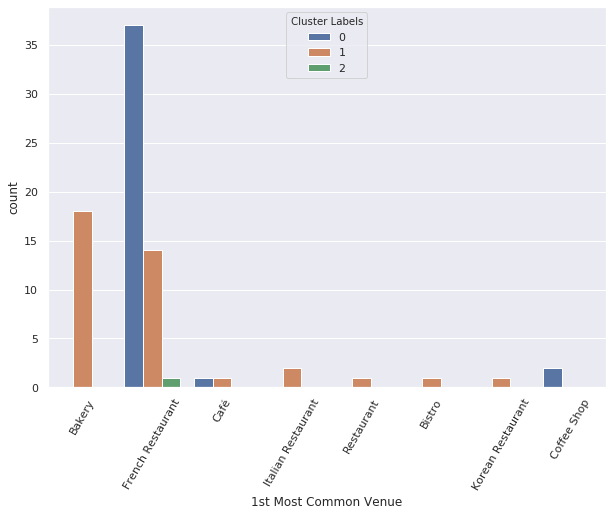

In [53]:

import seaborn as sns
ax = sns.countplot(x="1st Most Common Venue", hue="Cluster Labels", data=dfc)
sns.set(rc={'figure.figsize':(10, 7)})
fig = ax.get_figure()
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

Using k-means we have segmented Paris Neighborhood into three groups since we specified the algorithm to generate 3 clusters. The Neighborhood in each cluster are similar to each other in terms of the features included in the dataset.

Now we can create a profile for each group, considering the common characteristics of each cluster. For example, the 3 clusters can be:

1.**Cluster 1:French Restaurants**: In this cluster, we can notice that locations usually have French restaurants being the top most common restaurants.Peaple in this cluster prefer more frech style foods. 
       

2.**Cluster 2:Bakery&Divers Restaurants**: In this cluster, peaple prefer Bakery and others food style(Italien, korean,..) with the french food

3.**Cluster 3:Bel-Air**: it is an isolated cluster, it contain only Bel-Air neighborhood.